# Importing

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv("Total.csv")
df.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,data,Item_Categories
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,1,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,1,DR


# Dealing with Categorical Variables

## 1. Item_Identifier
NO CHANGE REQUIRED
Later we'll convert the categories into dummy variables.

## 2. Item_Fat_Content
**CATEGORIES NOT PROPERLY DEFINED**

In [4]:
df.loc[:,'Item_Fat_Content'].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Here as we can see the categories are not properly defined.<br>
Here first I'll convert all values as either "Low Fat" or "Regular".

In [8]:
# replacing 'LF' & 'low fat' with 'Low Fat'
df.loc[(df.loc[:,'Item_Fat_Content']=='LF') | (df.loc[:,'Item_Fat_Content']=='low fat'),'Item_Fat_Content']="Low Fat"

In [10]:
# Replacing 'reg' in 'Item_Fat_Content' with 'Regular'
df.loc[df.loc[:,'Item_Fat_Content']=='reg','Item_Fat_Content']="Regular"

In [11]:
# Again looking at the value_counts() after modifications
df.loc[:,'Item_Fat_Content'].value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

After Data Understanding Phase,<br>
For Model Building Phase we'll convert 'Low Fat' to 0 and 'Regular' to 1.

## 3. Item_Type
NO CHANGE REQUIRED

## 4. Outlet_Identifier
NO CHANGE REQUIRED

## 5. Outlet_Size
**Deal with MISSING VALUES.**

In [12]:
# Value Counts of different categories
df.loc[:,'Outlet_Size'].value_counts()

Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

In [13]:
# Number of Missing Values
df.loc[:,'Outlet_Size'].isna().sum()

4016

Since there are only 10 outlets.<br>
First let's find out which are the Outlets whose Data regarding 'Outlet_Size' is missing.

In [14]:
# Getting the 10 'Outlet_Identifiers'
df.loc[:,'Outlet_Identifier'].value_counts()

OUT027    1559
OUT013    1553
OUT046    1550
OUT035    1550
OUT049    1550
OUT045    1548
OUT018    1546
OUT017    1543
OUT010     925
OUT019     880
Name: Outlet_Identifier, dtype: int64

In [15]:
df.groupby('Outlet_Identifier')['Outlet_Size'].value_counts(dropna=False)

Outlet_Identifier  Outlet_Size
OUT010             NaN             925
OUT013             High           1553
OUT017             NaN            1543
OUT018             Medium         1546
OUT019             Small           880
OUT027             Medium         1559
OUT035             Small          1550
OUT045             NaN            1548
OUT046             Small          1550
OUT049             Medium         1550
Name: Outlet_Size, dtype: int64

Here we can see that we've 3 stores whose data corresponding to 'Outlet_Size' is missing.<br>
The stores are: 'OUT010' , 'OUT017', 'OUT045'<br>

* To impute the missing values, let's see if can get any information out of variables 'Outlet_Location_Type' and 'Outlet_Type'.
* Also let's look at the characteristics of the stores whose data is missing.

In [18]:
# OUT010
df.loc[df.loc[:,'Outlet_Identifier']=='OUT010',['Outlet_Location_Type','Outlet_Type']].head(1)

,Outlet_Location_Type,Outlet_Type
3,Tier 3,Grocery Store


In [19]:
df.loc[df.loc[:,'Outlet_Identifier']=='OUT017',['Outlet_Location_Type','Outlet_Type']].head(1)

,Outlet_Location_Type,Outlet_Type
9,Tier 2,Supermarket Type1


In [20]:
df.loc[df.loc[:,'Outlet_Identifier']=='OUT045',['Outlet_Location_Type','Outlet_Type']].head(1)

,Outlet_Location_Type,Outlet_Type
8,Tier 2,Supermarket Type1


In [21]:
df.groupby('Outlet_Type')['Outlet_Size'].value_counts(dropna=False)

Outlet_Type        Outlet_Size
Grocery Store      NaN             925
                   Small           880
Supermarket Type1  Small          3100
                   NaN            3091
                   High           1553
                   Medium         1550
Supermarket Type2  Medium         1546
Supermarket Type3  Medium         1559
Name: Outlet_Size, dtype: int64

In [22]:
df.groupby('Outlet_Location_Type')['Outlet_Size'].value_counts(dropna=False)

Outlet_Location_Type  Outlet_Size
Tier 1                Small          2430
                      Medium         1550
Tier 2                NaN            3091
                      Small          1550
Tier 3                Medium         3105
                      High           1553
                      NaN             925
Name: Outlet_Size, dtype: int64

In [23]:
df.groupby(['Outlet_Location_Type','Outlet_Type'])['Outlet_Size'].value_counts(dropna=False)

Outlet_Location_Type  Outlet_Type        Outlet_Size
Tier 1                Grocery Store      Small           880
                      Supermarket Type1  Medium         1550
                                         Small          1550
Tier 2                Supermarket Type1  NaN            3091
                                         Small          1550
Tier 3                Grocery Store      NaN             925
                      Supermarket Type1  High           1553
                      Supermarket Type2  Medium         1546
                      Supermarket Type3  Medium         1559
Name: Outlet_Size, dtype: int64

In [24]:
df.groupby(['Outlet_Type','Outlet_Location_Type'])['Outlet_Size'].value_counts(dropna=False)

Outlet_Type        Outlet_Location_Type  Outlet_Size
Grocery Store      Tier 1                Small           880
                   Tier 3                NaN             925
Supermarket Type1  Tier 1                Medium         1550
                                         Small          1550
                   Tier 2                NaN            3091
                                         Small          1550
                   Tier 3                High           1553
Supermarket Type2  Tier 3                Medium         1546
Supermarket Type3  Tier 3                Medium         1559
Name: Outlet_Size, dtype: int64

In [25]:
# Do we only have Small 'Grocery Store'??
df.groupby(['Outlet_Size','Outlet_Type','Outlet_Location_Type'])['Outlet_Establishment_Year'].mean()

Outlet_Size  Outlet_Type        Outlet_Location_Type
High         Supermarket Type1  Tier 3                  1987
Medium       Supermarket Type1  Tier 1                  1999
             Supermarket Type2  Tier 3                  2009
             Supermarket Type3  Tier 3                  1985
Small        Grocery Store      Tier 1                  1985
             Supermarket Type1  Tier 1                  1997
                                Tier 2                  2004
Name: Outlet_Establishment_Year, dtype: int64

Since there is no clear visible relationship between 'Outlet_Size', 'Outlet_Type', 'Outlet_Location_Type', therefore for now I will just impute the mode for missing values as of now.

In [33]:
# Let's assign "Grocery Stores" as 'Small' i.e. for 'Outlet_Identifier'=>OUT010 'Outlet_Size'=>'Small'
df.loc[df.loc[:,'Outlet_Identifier']=='OUT010','Outlet_Size']='Small'

In [34]:
df.loc[df.loc[:,'Outlet_Identifier']=='OUT045','Outlet_Size']='Medium'
df.loc[df.loc[:,'Outlet_Identifier']=='OUT017','Outlet_Size']='Medium'

In [35]:
df.loc[:,'Outlet_Size'].value_counts()

Medium    7746
Small     4905
High      1553
Name: Outlet_Size, dtype: int64

In [36]:
df.groupby('Outlet_Identifier')['Outlet_Size'].value_counts(dropna=False)

Outlet_Identifier  Outlet_Size
OUT010             Small           925
OUT013             High           1553
OUT017             Medium         1543
OUT018             Medium         1546
OUT019             Small           880
OUT027             Medium         1559
OUT035             Small          1550
OUT045             Medium         1548
OUT046             Small          1550
OUT049             Medium         1550
Name: Outlet_Size, dtype: int64

## 6. Outlet_Location_Type

## 7. Outlet_Type

As of now, no need for Data Cleaning

## 8. Item_Categories

# Dealing with Quantitative Variables

## 1. Item_Weight
Treat Missing Values

In [51]:
df['Item_Weight'].describe()

count    14204.000000
mean        12.793380
std          4.651716
min          4.555000
25%          8.710000
50%         12.600000
75%         16.750000
max         21.350000
Name: Item_Weight, dtype: float64

In [37]:
df.groupby('Item_Identifier')['Item_Weight'].mean().head(5)

Item_Identifier
DRA12    11.600
DRA24    19.350
DRA59     8.270
DRB01     7.390
DRB13     6.115
Name: Item_Weight, dtype: float64

In [38]:
for i in df.groupby('Item_Identifier')['Item_Weight'].mean().index:
    df.loc[df.loc[:,'Item_Identifier']==i,'Item_Weight']=df.groupby('Item_Identifier')['Item_Weight'].mean()[i]

In [39]:
df.loc[:,'Item_Weight'].isnull().sum()

0

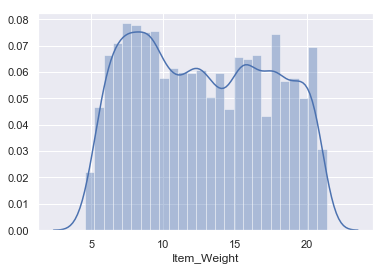

In [49]:
sns.distplot(df['Item_Weight'])

## 2. Item_Visibility
Items having visibility 0 must be looked at because if the product is not kept in the store then it will not give us any information. (There are 879 such rows out of 5481 rows, Therefore we can even consider removing those rows)

In [42]:
df.loc[df.loc[:,"Item_Visibility"]==0,'Item_Visibility'] = df['Item_Visibility'].median()

In [54]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,data,Item_Categories
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,1,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,1,DR
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,1,FD
3,FDX07,19.20,Regular,0.054021,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,1,FD
4,NCD19,8.93,Low Fat,0.054021,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,1,NC


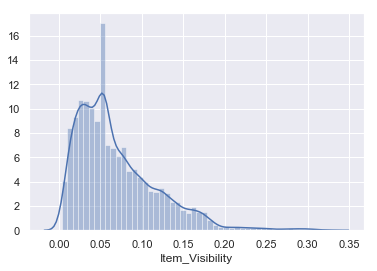

In [52]:
sns.distplot(df['Item_Visibility'])

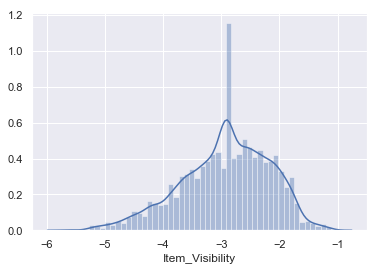

In [53]:
sns.distplot(np.log(df['Item_Visibility']))

## 3. Item_MRP

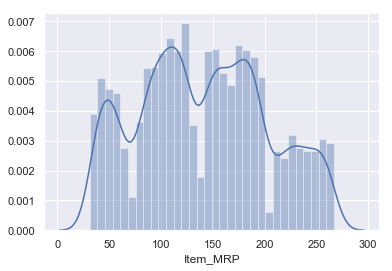

In [56]:
sns.distplot(df['Item_MRP'])

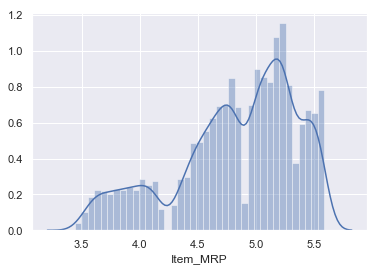

In [57]:
sns.distplot(np.log(df['Item_MRP']))

## 4. Outlet_Establishment_Year

In [72]:
df['Outlet_Establishment_Year'] = 2013-df['Outlet_Establishment_Year']

In [74]:
df['Outlet_Establishment_Year'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Establishment_Year, dtype: float64

In [75]:
df['Outlet_Establishment_Year'].value_counts()

28    2439
26    1553
14    1550
9     1550
16    1550
11    1548
4     1546
6     1543
15     925
Name: Outlet_Establishment_Year, dtype: int64

# Creating csv file for Cleaned Data

In [76]:
df.to_csv('Cleaned.csv',index=False)